## Predicting cyclist traffic in Paris

## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

Let's start by a really quick EDA, then we'll think about adding potentially relevent external data points to enrich our analysis.

In [86]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [87]:
df = pd.read_parquet(Path("data")/ "train.parquet")
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [88]:
#  Basic Overview
print("=== Basic Information ===")
print(df.info())
print("\n=== First few rows ===")
print(df.head())
print("\n=== Basic Statistics ===")
print(df.describe())

=== Basic Information ===
<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             

In [89]:
# Unique Values Analysis
print("\n=== Number of unique values per column ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


=== Number of unique values per column ===
counter_id: 56 unique values
counter_name: 56 unique values
site_id: 30 unique values
site_name: 30 unique values
bike_count: 998 unique values
date: 8974 unique values
counter_installation_date: 22 unique values
coordinates: 30 unique values
counter_technical_id: 30 unique values
latitude: 30 unique values
longitude: 30 unique values
log_bike_count: 998 unique values


In [90]:
# Temporal Analysis
# Convert date to datetime if not already
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.weekday >= 5

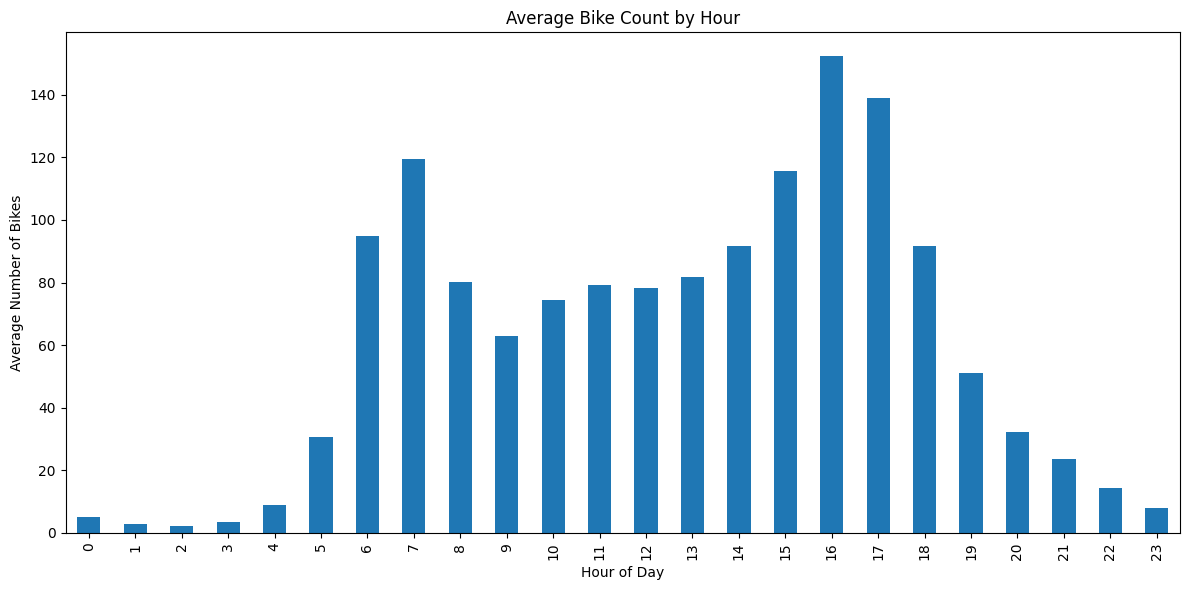

In [91]:

# Plot hourly patterns
plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hour')['bike_count'].mean()
hourly_avg.plot(kind='bar')
plt.title('Average Bike Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.tight_layout()
plt.show()


Kind of as expected people take velibs to go back and from work mostly (so around 7 until 4 or 5). So it would be worthwile to add in holidays in our analysis as external data because I think they can have a huge impact on the ending.

Maybe look up some stats/sondages about velib uses and when/why/who uses velib as part of our EDA.

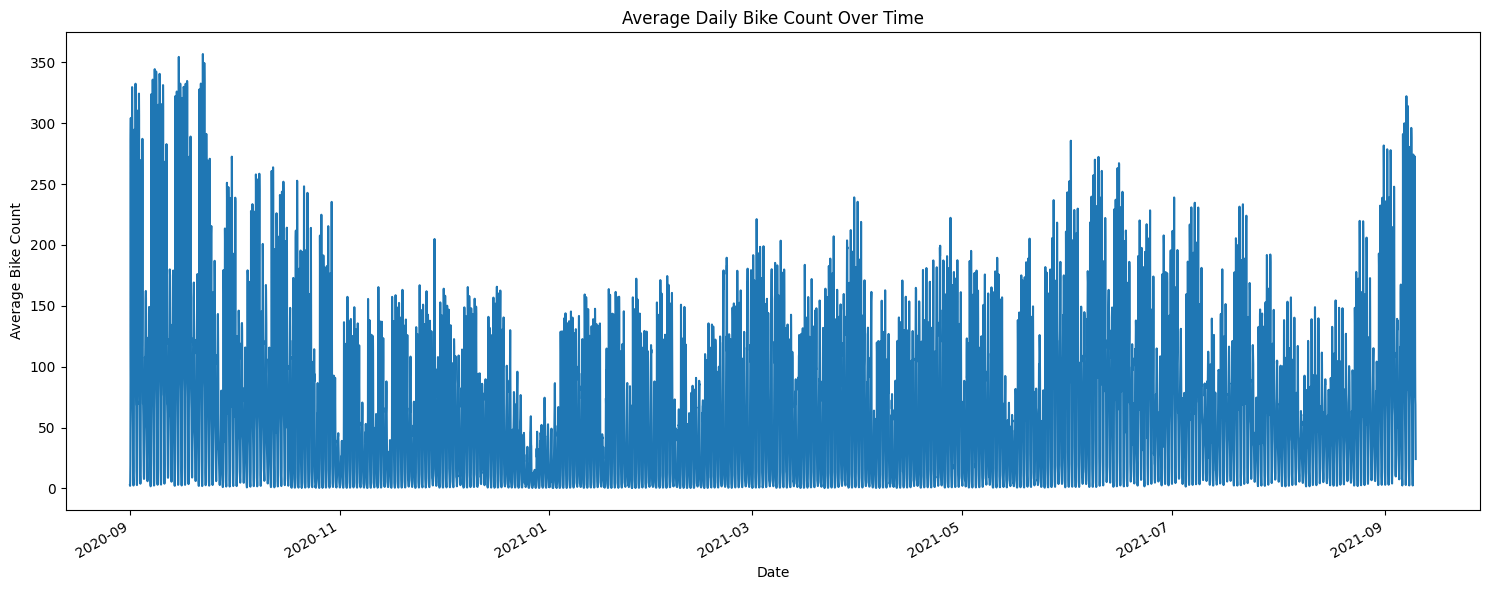

In [92]:

# Time Series View
plt.figure(figsize=(15, 6))
daily_counts = df.groupby('date')['bike_count'].mean()
daily_counts.plot()
plt.title('Average Daily Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Average Bike Count')
plt.tight_layout()
plt.show()


This seems to confirm my view, for example we can look at around end of decemeber most people are in vacation, it's cold and there is a sharp drop in velib use...

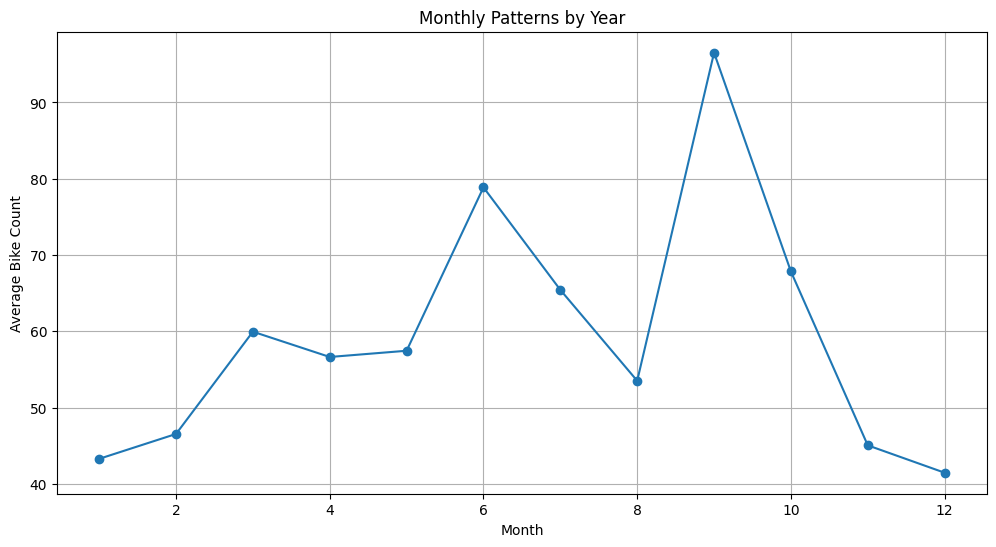

In [93]:
# Monthly patterns
monthly_traffic = df.groupby(['month'])['bike_count'].mean()
plt.figure(figsize=(12, 6))
monthly_traffic.T.plot(marker='o')
plt.title('Monthly Patterns by Year')
plt.xlabel('Month')
plt.ylabel('Average Bike Count')
plt.grid(True)
plt.show()


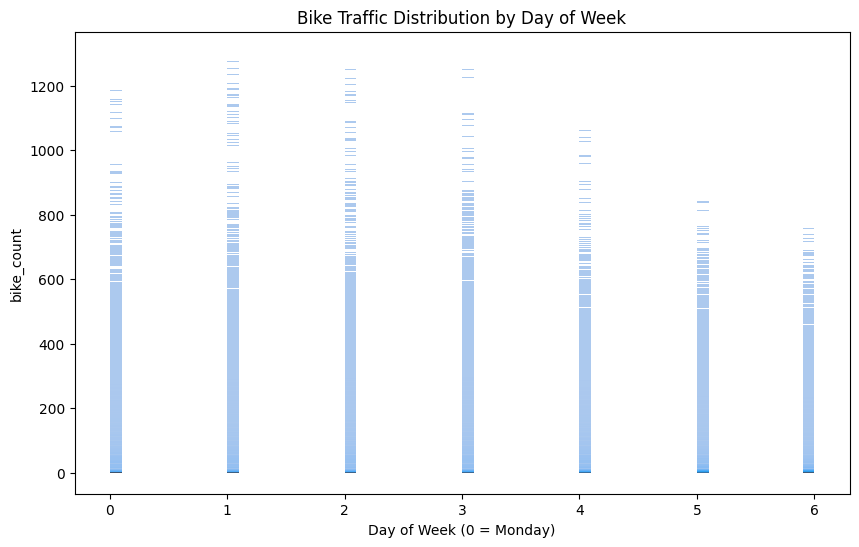

In [94]:

# 3. Weekly Patterns
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='day_of_week', y='bike_count')
plt.title('Bike Traffic Distribution by Day of Week')
plt.xlabel('Day of Week (0 = Monday)')
plt.show()

<Figure size 1200x600 with 0 Axes>

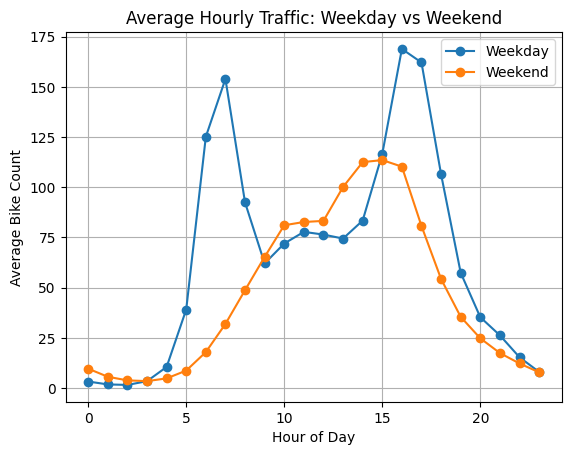

In [95]:

# 4. Daily Patterns
hourly_traffic = df.groupby(['hour', 'is_weekend'])['bike_count'].mean().unstack()
plt.figure(figsize=(12, 6))
hourly_traffic.plot(marker='o')
plt.title('Average Hourly Traffic: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Bike Count')
plt.legend(['Weekday', 'Weekend'])
plt.grid(True)
plt.show()

Let's work with data.gouv API to have a quick look at my knack about the effect of holidays...

In [96]:
import requests

def get_holidays_from_api(start_year=2020, end_year=2022):
    holidays = []
    for year in range(start_year, end_year):
        url = f"https://calendrier.api.gouv.fr/jours-feries/metropole/{year}.json"
        response = requests.get(url)
        if response.status_code == 200:
            year_holidays = response.json()
            for date, name in year_holidays.items():
                holidays.append({'date': date, 'holiday_name': name})

    return pd.DataFrame(holidays)

In [97]:
holidays = get_holidays_from_api()

In [98]:
holidays

,date,holiday_name
0,2020-01-01,1er janvier
1,2020-04-13,Lundi de Pâques
2,2020-05-01,1er mai
3,2020-05-08,8 mai
4,2020-05-21,Ascension
5,2020-06-01,Lundi de Pentecôte
6,2020-07-14,14 juillet
7,2020-08-15,Assomption
8,2020-11-01,Toussaint
9,2020-11-11,11 novembre


In [99]:
holidays['date'] = pd.to_datetime(holidays['date'])
df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)

<Figure size 1500x600 with 0 Axes>

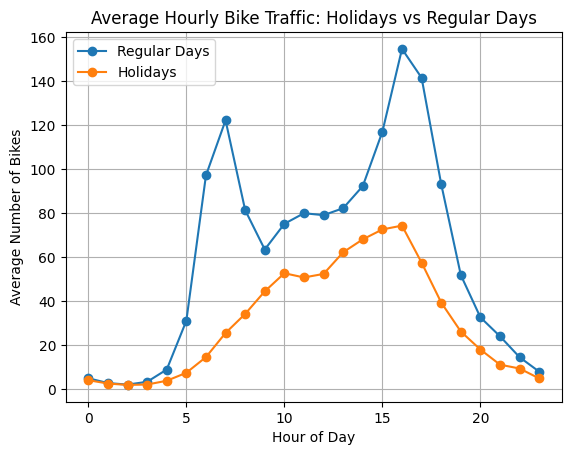

In [100]:
# 2. Compare traffic patterns
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays'])
plt.grid(True)
plt.show()

Nice !! Big impact of holidays ! We will have to add it in our data set in a way (useful external data). Maybe with Zone C vacations also (but do parents use velib ?? we will have to chekc)

In [101]:
# Calculate average traffic by counter first
counter_traffic = df.groupby('counter_name')['bike_count'].mean().sort_values(ascending=False)

# Print top counters
print("Top 5 busiest counters:")
print(counter_traffic.head())

Top 5 busiest counters:
counter_name
Totem 73 boulevard de Sébastopol S-N    221.999889
Totem 64 Rue de Rivoli O-E              172.913974
Totem 73 boulevard de Sébastopol N-S    166.916871
67 boulevard Voltaire SE-NO             125.982282
Totem 64 Rue de Rivoli E-O              113.202028
Name: bike_count, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_2032\3158012192.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counter_traffic = df.groupby('counter_name')['bike_count'].mean().sort_values(ascending=False)


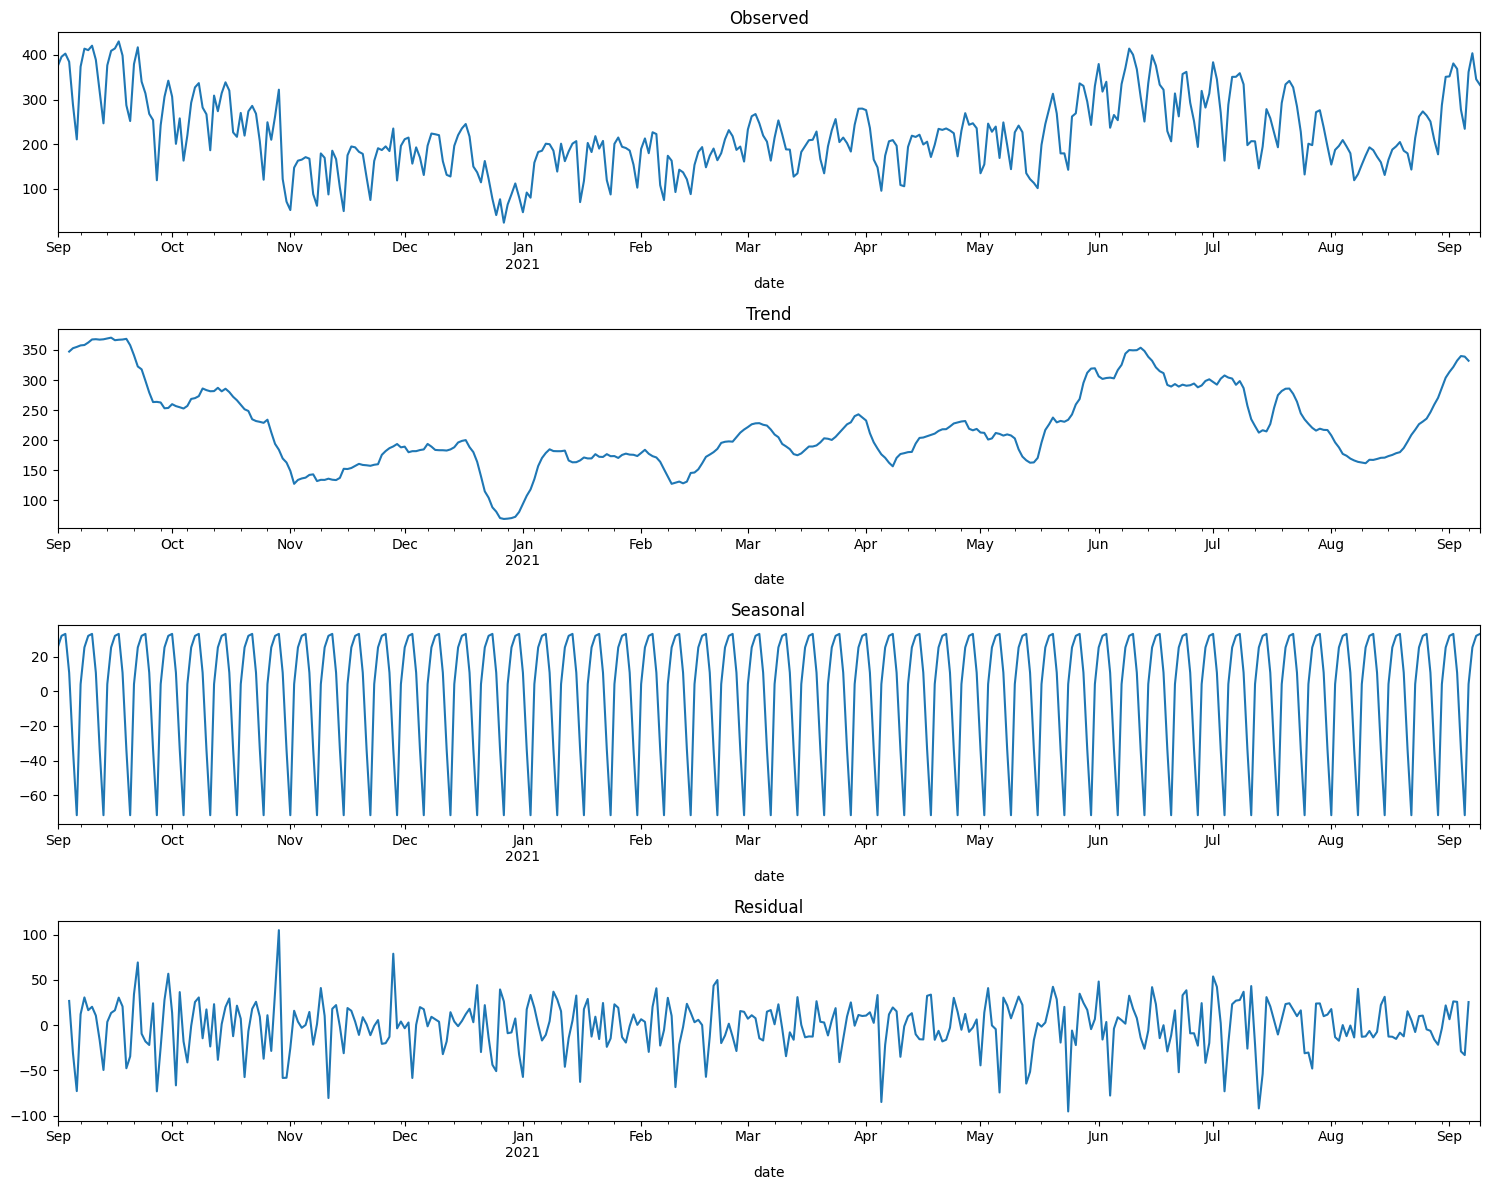

In [102]:
# 6. Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Choose one busy counter for decomposition
busy_counter = counter_traffic.index[0]
counter_data = df[df['counter_name'] == busy_counter].set_index('date')['bike_count']
daily_data = counter_data.resample('D').mean()

decomposition = seasonal_decompose(daily_data, period=7)  # 7 days for weekly seasonality
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

Looking at this time series decomposition, we can observe several interesting patterns:

1. Observed Data (Top Plot):
- Strong weekly seasonality (regular spikes)
- Lower traffic during winter months (December-January)
- Higher traffic during summer months (June-September)
- Overall values range from about 100 to 400 bikes per day

2. Trend Component (Second Plot):
- Clear seasonal trend with lower values in winter
- Major dip in January 2021 (possibly due to COVID restrictions or weather)
- General upward trend from January to June 2021
- Values range from around 100 to 350 bikes
- Another rise starting in September

3. Seasonal Component (Third Plot):
- Very regular weekly pattern
- Amplitude of about ±60 bikes
- Consistent throughout the year, suggesting the weekly pattern is stable
- Clear weekday/weekend effect

4. Residual Component (Bottom Plot):
- Mostly random fluctuations between -50 and +50 bikes
- Some larger spikes suggesting special events or unusual days
- No obvious pattern, which is good for a decomposition

In [103]:

# 7. Basic Statistics
print("\nBasic Statistics by Day Type:")
print(df.groupby('is_weekend')['bike_count'].agg(['mean', 'std', 'median']))


Basic Statistics by Day Type:
                 mean        std  median
is_weekend                              
False       65.590930  92.656993    34.0
True        46.535432  71.430229    19.0


In [104]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_parquet("data/train.parquet")
df['date'] = pd.to_datetime(df['date'])


In [105]:

# Create cyclical features
def create_cyclical_features(df):
    df = df.copy()
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    return df

df = create_cyclical_features(df)
df

KeyError: 'hour'

In [ ]:

# Define feature groups
numeric_features = [
    'latitude',
    'longitude',
    'hour_sin',
    'hour_cos',
    'month_sin',
    'month_cos'
]

categorical_features = [
    'counter_name',
    'day_of_week',
    'is_weekend'
]

# Define preprocessing steps
numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
)

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'hour_sin', 'hour_cos',
                                                   'month_sin', 'month_cos']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['counter_name',
                                                   'day_of_week',
                                                   'is_weekend'])])),
                ('regressor', Ridge())])

In [ ]:

# Prepare X and y
X = df[numeric_features + categorical_features]
y = df['log_bike_count']

In [106]:

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
train_scores = []
val_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Fit model
    model.fit(X_train, y_train)

    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    train_scores.append(train_rmse)
    val_scores.append(val_rmse)

    print(f'Fold {fold+1} - Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')

print(f'\nAverage Train RMSE: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}')
print(f'Average Validation RMSE: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}')

Fold 1 - Train RMSE: 0.8900, Validation RMSE: 1.0218
Fold 2 - Train RMSE: 0.8963, Validation RMSE: 1.1204
Fold 3 - Train RMSE: 0.9083, Validation RMSE: 1.1362
Fold 4 - Train RMSE: 0.9005, Validation RMSE: 1.1161
Fold 5 - Train RMSE: 0.9016, Validation RMSE: 1.4511

Average Train RMSE: 0.8993 ± 0.0061
Average Validation RMSE: 1.1691 ± 0.1466


In [107]:

# Get feature names after transformation
def get_feature_names(column_transformer):
    feature_names = []

    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if isinstance(pipe, Pipeline):
                if isinstance(pipe.steps[-1][1], OneHotEncoder):
                    feature_names.extend(pipe.steps[-1][1].get_feature_names_out(features))
                else:
                    feature_names.extend(features)
            else:
                if isinstance(pipe, OneHotEncoder):
                    feature_names.extend(pipe.get_feature_names_out(features))
                else:
                    feature_names.extend(features)

    return feature_names

# Get feature importance
feature_names = get_feature_names(model.named_steps['preprocessor'])
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(model.named_steps['regressor'].coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

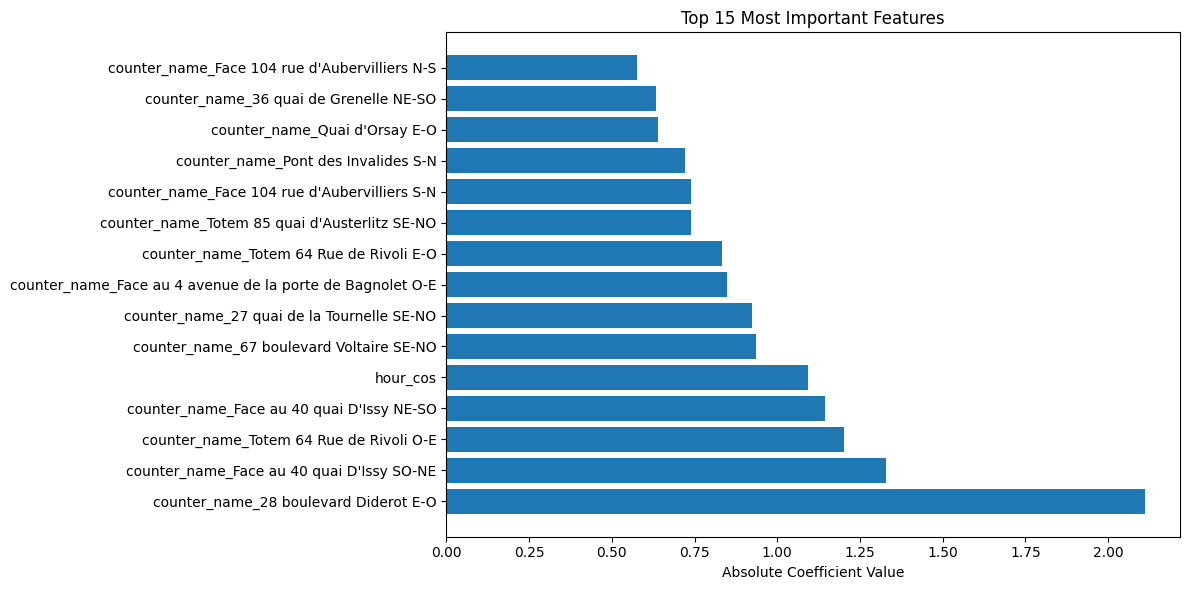

In [108]:

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.title('Top 15 Most Important Features')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()


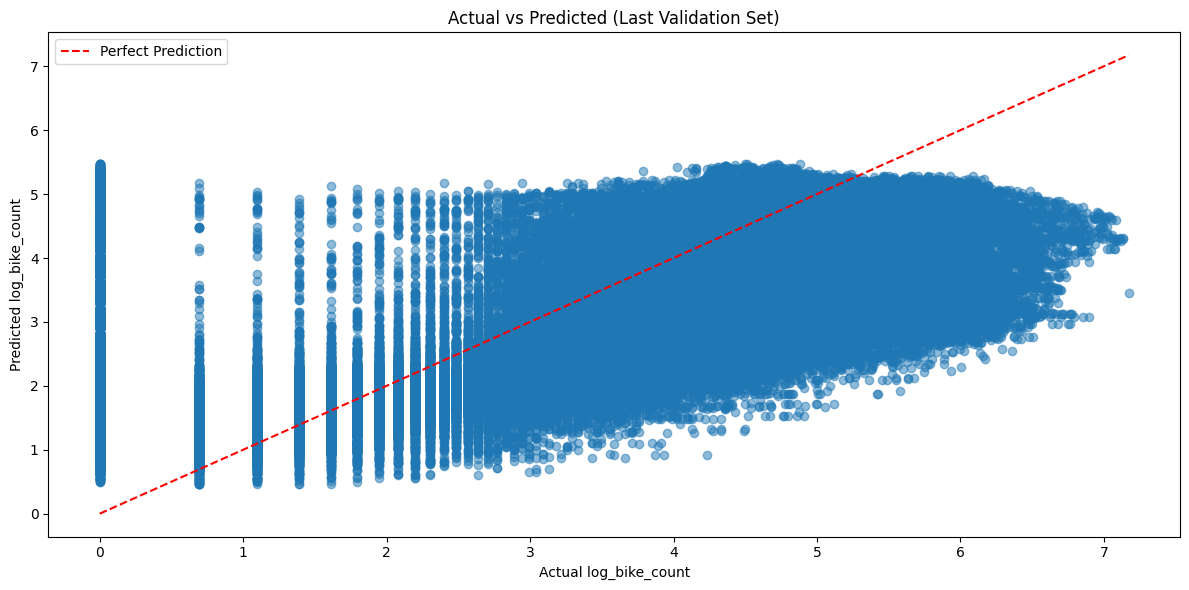

In [109]:

# Plot actual vs predicted for last validation set
plt.figure(figsize=(12, 6))
plt.scatter(y_val, val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual log_bike_count')
plt.ylabel('Predicted log_bike_count')
plt.title('Actual vs Predicted (Last Validation Set)')
plt.legend()
plt.tight_layout()
plt.show()